# 2020_dl-nn_mnist-handwritten-digit-classifer

## Purpose

This is a deep neural network that I am building from my notes from this class: [Udacity - Intro to Deep Learning with Pytorch](https://classroom.udacity.com/courses/ud188/lessons/c5706f76-0e30-4b48-b74e-c19fafc33a75/concepts/0d735345-f080-49c4-8fbf-a68012923f50). I want to reinforce what I learned from Lessons 4 and 5 by building a complete (basic) network using only my notes and the Pytorch documentation as references.

## Plan

- Transform and load MNIST handwritten digits data
- Define a neural network class
- Select an error function and optimizer for the network
- Train the model with validation
  - Print training and testing loss each epoch
  - Graph?
- Save the model
- Load the model from file
- Test the model

In [1]:
import torch

### Download, Transform, and Load the Data

In [2]:
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST("./2020_data_mnist", train=True, transform=transform, download=True)
test_data = datasets.MNIST("./2020_data_mnist", train=False, transform=transform, download=False)

# Percent of training data to split off for validation
valid_size = 0.2

data_len = len(train_data)
indices = list(range(data_len))
np.random.shuffle(indices)
split = int(np.floor(valid_size * data_len))
valid_indices, train_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Visualize the Data

64 48000


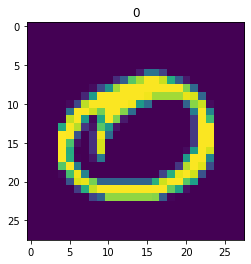

In [3]:
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = dataiter.next()

# We will use these values to average the loss values during training, so want to see them now
print(images.size(0), len(train_loader.sampler))

image = images[0].view(28, 28)
plt.imshow(image)
plt.title(int(labels[0]))
plt.show()

### Define the Model

In [4]:
from torch import nn
import torch.nn.functional as F

input_features = 28*28 # Number of pixels in a 28x28 image

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        hidden_layers = 512 # Define size of hidden layers
        outputs = 10 # We have ten outputs, because there are 10 classes: integers 0 - 9
        
        # Define a network with three linear layers
        self.fc1 = nn.Linear(input_features, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, hidden_layers)
        self.fc3 = nn.Linear(hidden_layers, outputs)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        
        # Flatten the input image
        x = x.view(-1, input_features)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        # The softmax function will be applied by the loss function
        # nn.CrossEntropyLoss(), so we don't need it here
        x = self.fc3(x)
        
        return x
    
model = Classifier()
model

Classifier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [5]:
loss_funct = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

### Train the Model

In [6]:
epochs = 30

# Losses per epoch
train_losses = []
valid_losses = []

# Minimum validation loss
valid_loss_min = np.Inf

for e in range(epochs):
    
    # Loss per epoch
    train_loss = 0
    valid_loss = 0
    
    # Training loop
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_funct(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)
        
    # Validation loop
    model.eval()
    for images, labels in valid_loader:
        output = model(images)
        loss = loss_funct(output, labels)
        valid_loss += loss.item()*images.size(0)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_losses.append(valid_loss)
    
    # Early stopping
    if valid_loss > valid_loss_min:
        break
    else:
        valid_loss_min = valid_loss
        
    # Telemetry
    print("Epoch:", e+1, "\tTraining loss:", train_loss, "\tValidation loss:", valid_loss)
    
    

Epoch: 1 	Training loss: 1.8903843593597411 	Validation loss: 1.2456121816635133
Epoch: 2 	Training loss: 0.9211571972370147 	Validation loss: 0.6319581549962362
Epoch: 3 	Training loss: 0.6015076321760814 	Validation loss: 0.4796861864725749
Epoch: 4 	Training loss: 0.49520129056771595 	Validation loss: 0.4160646815697352
Epoch: 5 	Training loss: 0.44397508360942206 	Validation loss: 0.37875874296824136
Epoch: 6 	Training loss: 0.4087307212948799 	Validation loss: 0.3542949155966441
Epoch: 7 	Training loss: 0.38505113914608957 	Validation loss: 0.33615836131572724
Epoch: 8 	Training loss: 0.3662887257734935 	Validation loss: 0.32256037497520446
Epoch: 9 	Training loss: 0.349906762500604 	Validation loss: 0.31092374845345816
Epoch: 10 	Training loss: 0.3359996593395869 	Validation loss: 0.29958967673778536
Epoch: 11 	Training loss: 0.3238604234755039 	Validation loss: 0.2886936815579732
Epoch: 12 	Training loss: 0.31395610922574996 	Validation loss: 0.2802709978024165
Epoch: 13 	Traini

### Save the Model

Save the models `state_dict`, which contains the trained weights and biases, instead of the whole model.

In [11]:
path = "2020_dl-nn_mnist-handwritten-digit-classifer.pt"
torch.save(model.state_dict(), path)

### Load the Model
Define a new `model` with the same class (so it will have the same number of layers and neurons as the pretrained
model's `state_dict`) and load the trained parameters into it.

In [12]:
model = Classifier()
model.load_state_dict(torch.load(path))
model.eval()
model

Classifier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Test the Model

In [30]:
test_loss = 0
test_accuracy = 0

for images, labels in test_loader:
    probabilites = model(images)
    
    ### Calculate the Accuracy of the Model ###
    # extract the most likely class (the model's prediction) for each of the 64
    # images in the test_loader batch. topk() the indeces of the k largest elements of
    # tensor as its second output, but since our classes are the integers 0 to 9, in
    # order, this is equivalent to the predicted class
    top_prob, top_class = probabilites.topk(1, dim=1)
    
    # True (1) if model's prediction is correct, False (0) otherwise
    prediction_accuracies = top_class == labels.view(*top_class.shape)
    
    # Add the mean of the accuracies for all of the images
    test_accuracy += torch.mean(prediction_accuracies.type(torch.FloatTensor))
    
    ### Calculate the Testing Loss ###
    loss = loss_funct(probabilites, labels)
    test_loss += loss.item()*images.size(0)
    
test_loss = test_loss/(len(test_loader.sampler))    
test_accuracy = test_accuracy/len(test_loader)
test_accuracy, test_loss, probabilites[0]

(tensor(0.0995),
 2.315855238723755,
 tensor([-0.0182, -0.2432,  0.0253,  0.0093, -0.0492, -0.0940, -0.1480, -0.0572,
         -0.0662, -0.0955], grad_fn=<SelectBackward>))

### Visualize the Results

Text(0.5, 1.0, '7')

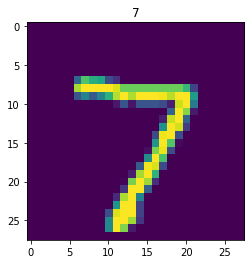

In [36]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

image = images[0].view(28, 28)
plt.imshow(image)
plt.title(int(labels[0]))

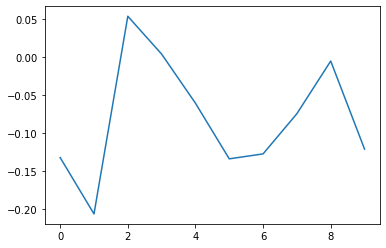

In [37]:
probabilites = model(images)
probability = probabilites[0].detach().numpy()

plt.plot(probability)
plt.title()

plt.show()